# Cell classification neural network model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [2]:
# Set random seeds for reproducibility
SEED = 42  # You can choose any integer value
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Image Processing Functions and Feature Extraction

In [3]:
# Function 1: Binary Thresholding (Inverted)
def apply_binary_threshold(image, threshold_value=80):
    """
    Apply binary thresholding (inverted) to a grayscale image.
    
    Parameters:
    - image: Grayscale image to be thresholded.
    - threshold_value: Threshold value for binarization (default=80).
    
    Returns:
    - thresholded_image: Binary image (inverted).
    """
    if image is None:
        raise ValueError("The input image is None.")
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    return thresholded_image

# Function 2: Calculate Contrast using GLCM
def calculate_contrast(grayscale_image):
    """
    Calculate contrast using the Grey Level Co-occurrence Matrix (GLCM) of a grayscale image.
    
    Parameters:
    - grayscale_image: Input grayscale image.
    
    Returns:
    - contrast: Contrast value calculated from GLCM.
    """
    if grayscale_image is None:
        raise ValueError("The input grayscale image is None.")
    
    glcm = graycomatrix(grayscale_image, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    return contrast

# Function 3: Count Pixels in the region of interest
def count_pixels(binary_image):
    """
    Count the number of white pixels (value 255) in the binary image.
    
    Parameters:
    - binary_image: Binary image resulting from thresholding.
    
    Returns:
    - pixel_count: Number of white pixels (255) in the binary image.
    """
    if binary_image is None:
        raise ValueError("The input binary image is None.")
    
    pixel_count = np.sum(binary_image == 255)
    return pixel_count

# Function to process a single image and extract features
def process_image(image, gray_image):
    """
    Process a single image to calculate binary threshold, contrast, and pixel count.
    
    Parameters:
    - image: Original image (in color, for visualization purposes).
    - gray_image: Grayscale version of the image.
    
    Returns:
    - Dictionary of features (contrast, pixel count).
    """
    if image is None or gray_image is None:
        raise ValueError("Input images are None.")
    
    binary_image = apply_binary_threshold(gray_image)
    contrast = calculate_contrast(gray_image)
    pixel_count = count_pixels(binary_image)

    return {"Contrast": contrast, "Pixel Count": pixel_count}

## Loading Images and Feature Extraction

In [4]:
# Function to extract features from all images in a directory and assign labels
def extract_features_and_labels(directory, label):
    """
    Extract features and corresponding labels from a set of images in a directory.
    
    Parameters:
    - directory: Directory containing the images.
    - label: The label associated with the class (0 for Basófilos, 1 for Eritroblastos).
    
    Returns:
    - features: List of feature vectors.
    - labels: List of labels corresponding to the features.
    """
    features = []
    labels = []

    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory {directory} does not exist.")

    for image_name in sorted(os.listdir(directory)):
        image_path = os.path.join(directory, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Extract features for the image
        features_dict = process_image(img, gray_img)
        feature_vector = [features_dict['Contrast'], features_dict['Pixel Count']]

        features.append(feature_vector)
        labels.append(label)

    return features, labels

In [5]:
# Project directories
base_dir = os.getcwd()  # Use the current working directory

# Define relative paths to the training directories
basofilos_train_dir = os.path.join(base_dir, 'data', 'Data_Cells_Train', 'Basofilos_train')
eritroblasto_train_dir = os.path.join(base_dir, 'data', 'Data_Cells_Train', 'Eritroblasto_train')

In [6]:
# Extract features for both training classes
basofilos_features, basofilos_labels = extract_features_and_labels(basofilos_train_dir, 0)  # Label basófilo as 0
eritroblasto_features, eritroblasto_labels = extract_features_and_labels(eritroblasto_train_dir, 1)  # Label eritroblasto as 1

# Combine the features and labels from both classes
X = np.array(basofilos_features + eritroblasto_features)
y = np.array(basofilos_labels + eritroblasto_labels)

# Split the data into training and validation sets (with fixed random_state for reproducibility)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Now extract features for the test set
basofilos_test_dir = os.path.join(base_dir, 'data', 'Data_Cells_Test', 'Inference', 'Basofilos_inference')
eritroblasto_test_dir = os.path.join(base_dir, 'data', 'Data_Cells_Test', 'Inference', 'Eritoblastos_inference')

basofilos_test_features, basofilos_test_labels = extract_features_and_labels(basofilos_test_dir, 0)  # Label basófilo as 0
eritroblasto_test_features, eritroblasto_test_labels = extract_features_and_labels(eritroblasto_test_dir, 1)  # Label eritroblasto as 1

# Combine the test features and labels from both classes
X_test = np.array(basofilos_test_features + eritroblasto_test_features)
y_test = np.array(basofilos_test_labels + eritroblasto_test_labels)

## Creating and Training the Model

In [7]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model with regularization and dropout
model = tf.keras.Sequential([
    # Input layer for 2 features: contrast and pixel count
    tf.keras.layers.InputLayer(input_shape=(2,)),  
    
    # First hidden layer with 16 neurons, ReLU activation, and L2 regularization to prevent overfitting
    tf.keras.layers.Dense(16, activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001)),  
    
    # Dropout layer to randomly deactivate 20% of neurons during training
    Dropout(0.2),
    
    # Second hidden layer with 8 neurons, ReLU activation, and L2 regularization
    tf.keras.layers.Dense(8, activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001)),  
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss for classification
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Early stopping callback to stop training if the validation loss does not improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), 
                    batch_size=8, callbacks=[early_stopping])

Epoch 1/100


c:\Users\lufec\anaconda3\envs\cell_classification\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3586 - loss: 0.7261 - val_accuracy: 0.8333 - val_loss: 0.7017
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5747 - loss: 0.7058 - val_accuracy: 0.9583 - val_loss: 0.6680
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8197 - loss: 0.6710 - val_accuracy: 0.9583 - val_loss: 0.6376
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8500 - loss: 0.6459 - val_accuracy: 0.9583 - val_loss: 0.6108
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9539 - loss: 0.6024 - val_accuracy: 0.9583 - val_loss: 0.5837
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.5902 - val_accuracy: 0.9583 - val_loss: 0.5560
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.5660 - val_accuracy: 0.9583 - val_loss: 0.5279
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.5198 - val_accuracy: 0.9583 - val_loss: 0.

## Evaluation and Visualization

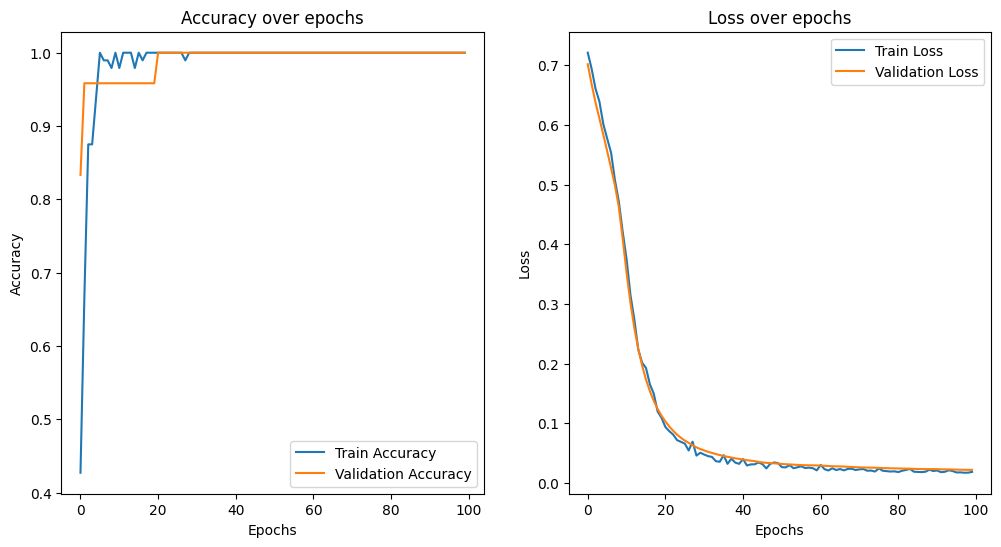

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.0161
Test Loss: 0.0161
Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


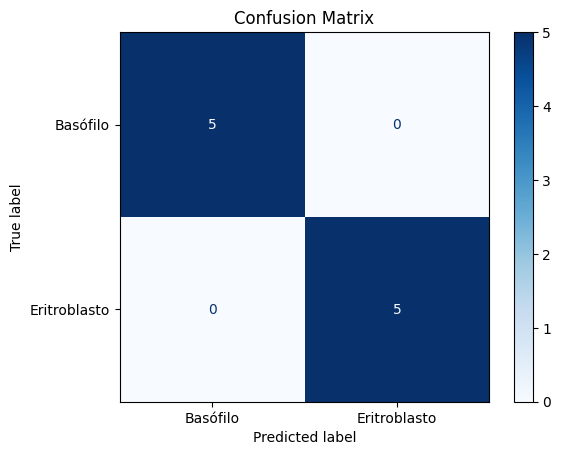

In [8]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the trained model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Basófilo", "Eritroblasto"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()